# InceptionNet for CIFAR10 + more data

## Load data

In [1]:
import cifar10_loader
import matplotlib.pyplot as plt

In [2]:
train_x, train_y, val_x, val_y = cifar10_loader.load_data(limit=5, shuffle=True)

In [3]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(49900, 32, 32, 3)
(49900,)
(100, 32, 32, 3)
(100,)


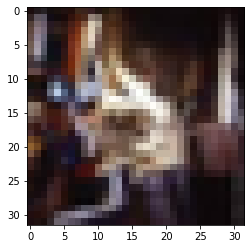

In [4]:
plt.imshow(train_x[0])

## Model

In [5]:
import tensorflow as tf
import kerastuner as kt

In [63]:
IMAGE_SIZE = 225
BATCH_SIZE = 32
TRAIN_LAYER_LIMIT = 10
LEARNING_RATE = 1e-5

In [64]:
def get_modified_inception_net():
    inception_net = tf.keras.applications.inception_v3.InceptionV3(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    if TRAIN_LAYER_LIMIT == 0:
        for layer in inception_net.layers:
            layer.trainable = False
    else:
        for layer in inception_net.layers[TRAIN_LAYER_LIMIT:]:
            layer.trainable = False
    my_inception_net_model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))),
        inception_net,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    my_inception_net_model.compile(adam, 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return my_inception_net_model

In [65]:
my_inception_net_model = get_modified_inception_net()

In [66]:
validation_accuracy_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
)
training_accuracy_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=7,
)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.6,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=1e-7
)
callbacks = [validation_accuracy_callback, training_accuracy_callback, reduce_lr_on_plateau]

In [67]:
history = my_inception_net_model.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    validation_data=(val_x, val_y),
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
1560/1560 [==============================] - 570s 362ms/step - loss: 2.0899 - accuracy: 0.3557 - val_loss: 0.8551 - val_accuracy: 0.7300
Epoch 2/100
1560/1560 [==============================] - 546s 350ms/step - loss: 1.0945 - accuracy: 0.6268 - val_loss: 0.7173 - val_accuracy: 0.7700
Epoch 3/100
1560/1560 [==============================] - 547s 350ms/step - loss: 0.9160 - accuracy: 0.6891 - val_loss: 0.6365 - val_accuracy: 0.7900
Epoch 4/100
1560/1560 [==============================] - 546s 350ms/step - loss: 0.8080 - accuracy: 0.7268 - val_loss: 0.6248 - val_accuracy: 0.7800
Epoch 5/100
1560/1560 [==============================] - 547s 351ms/step - loss: 0.7052 - accuracy: 0.7595 - val_loss: 0.5656 - val_accuracy: 0.8300
Epoch 6/100
1560/1560 [==============================] - 548s 351ms/step - loss: 0.6420 - accuracy: 0.7834 - val_loss: 0.5175 - val_accuracy: 0.8400
Epoch 7/100
1560/1560 [==============================] - 550s 352ms/step - loss: 0.5888 - accuracy: 0.7984

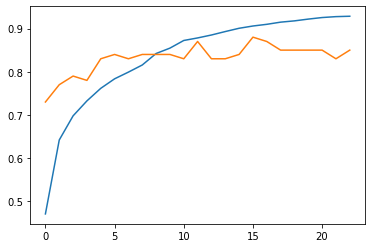

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [69]:
history_dict = {}
for key, value in history.history.items():
    history_dict[str(key)] = [float(i) for i in value]

In [70]:
import json
with open('lr_{0}_{1}x{1}_{2}.json'.format(LEARNING_RATE, IMAGE_SIZE, TRAIN_LAYER_LIMIT), 'w') as f:
    json.dump(history_dict, f)

In [71]:
my_inception_net_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 225, 225, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              104859648 
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)             